# Тетрадка содержит код для составления расписания и маршрутов объезда банкоматов

Данные для моделирования 

    - величина % в годовых, которую банк платит за неинкассированную сумму денег в терминале - 2 (т.е. сумма за день = остаток * 2/100/365);
    - стоимость обслуживания одного терминала в случае его инкассирования = 0,01% от суммы инкассации, но не менее 100 рублей (т.е. для суммы 50000 = 100, для суммы 1500000 = 150);
    - максимально допустимая сумма денег в терминале - 1000000;
    - максимально допустимое время, в течение которого терминал можно не обслуживать - 14 дней;
    - стоимость одного броневика на день - 20000;
    - начало и конец рабочего дня броневиков - c 08:00 по 20:00 мск. времени;
    - время простоя броневика на точке (время на инкассирование) - 10 минут


Возьмём терминал 406136: 
На утро 01.09 остаток = 160000.

Если его обслужить 01.09 и забрать 160000, то остаток на вечер будет = 0, платить за фондирование 01.09 не надо. Но будут издержки = 100 руб. за обслуживание.
1.1. На утро 02.09 остаток станет = 90000. Добавятся 90000 из оборотов 01.09. 

Если его не обслужить 01.09, то на вечер 01.09 остаток будет = 160000 и 01.09 у вас возникают издержки, связанные с фондированием = 7.45. Издержек за обслуживание не будет.
2.1. На утро 02.09 остаток станет = 250000 (160000 + 90000 поступлений за 01.09).
	2.1.1. Если 02.09 обслужить терминал, то остаток на вечер = 0. Фондирование = 0. Издержки за обслуживание = 100.
	2.1.2. Если 02.09 не обслуживать терминал, то остаток на вечер = 250000. Фондирование = 13.70. Издержки за обслуживание = 0.


In [13]:
%load_ext autoreload

from typing import List, Tuple, Optional, Dict
from warnings import warn

import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from bank_schedule.ortools_tsp import solve_tsp_ortools

from bank_schedule.data import Data, distances_matrix_from_dataframe
from bank_schedule.helpers  import calc_cartesian_coords
from bank_schedule import forecast, helpers, cluster, scheduler, ortools_tsp
from bank_schedule import plot as bsplot
from bank_schedule.constants import RAW_DATA_FOLDER, INTERIM_DATA_FOLDER

from bank_schedule import output, check_conditions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
loader = Data(RAW_DATA_FOLDER)
distances_df = loader.get_distance_matrix()
geo_df = loader.get_geo_TIDS()
incomes_df = loader.get_money_in()

initial_residuals = scheduler.get_initial_resuduals(loader,
                                                    last_collection_method='constant')

In [15]:
# Оценим теоретически достижимое максимальное число точек,
# которое может обслужить одна машина за день
sort_dist = distances_df.sort_values(by='Total_Time')

# прибавляем ко времени пути время на инкассацию
sort_dist['Total_Time'] += 10

# считаем куммулятивную сумму так, как будто все близкие точки попали в один кластер
# и мы их последовательно инкассируем
sort_dist['cumsum_time'] = sort_dist['Total_Time'].cumsum()

# смотрим, сколько точек мы успели объехать
max_tids = sort_dist[sort_dist['cumsum_time'] < 12 * 60].shape[0]
print('Максимальное теоретически достижимое число точек на 1 машину:', max_tids)

Максимальное теоретически достижимое число точек на 1 машину: 70


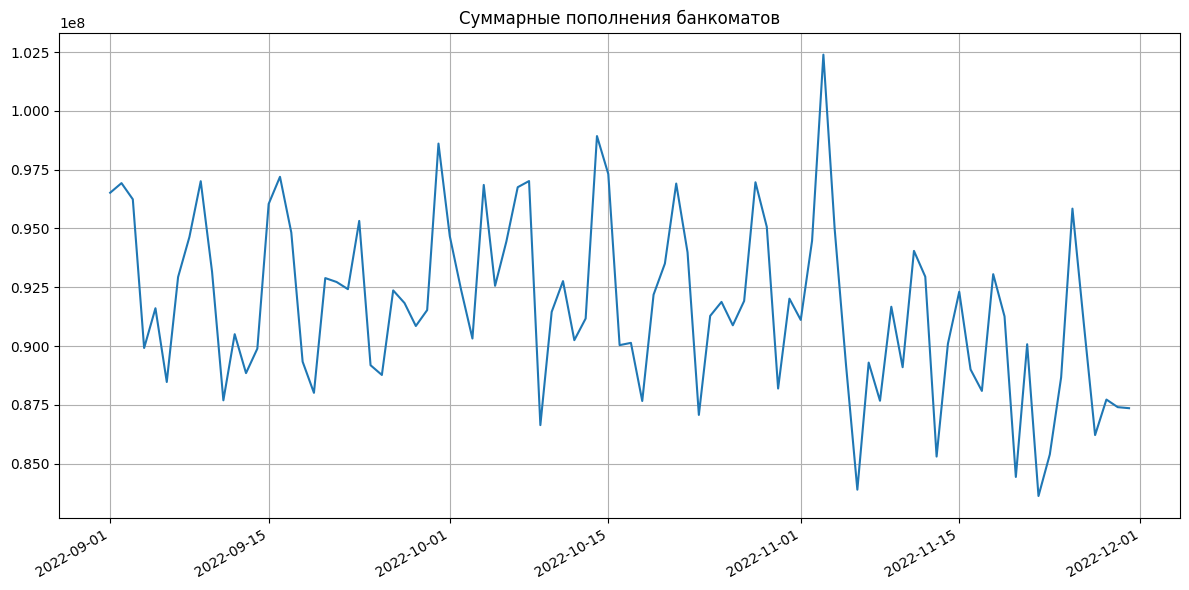

In [16]:
summary_incomes = incomes_df.groupby('date')['money_in'].sum()

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(summary_incomes)
plt.title('Суммарные пополнения банкоматов')
fig.autofmt_xdate()
plt.tight_layout()
plt.grid()
plt.show()

In [17]:
hist_mdl = forecast.ForecastHistorical()
lgbm_mdl = forecast.IncomeForecastLGBM()

Настроим параметры шедулера на исторических данных так, чтобы не было скачков в количестве банкоматов, которые надо обслужить обязательно в текущий день

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:265: UserWarning:

Дата 2022-08-31 00:00:00 не найдена в данных, прогнозируем средним по TID



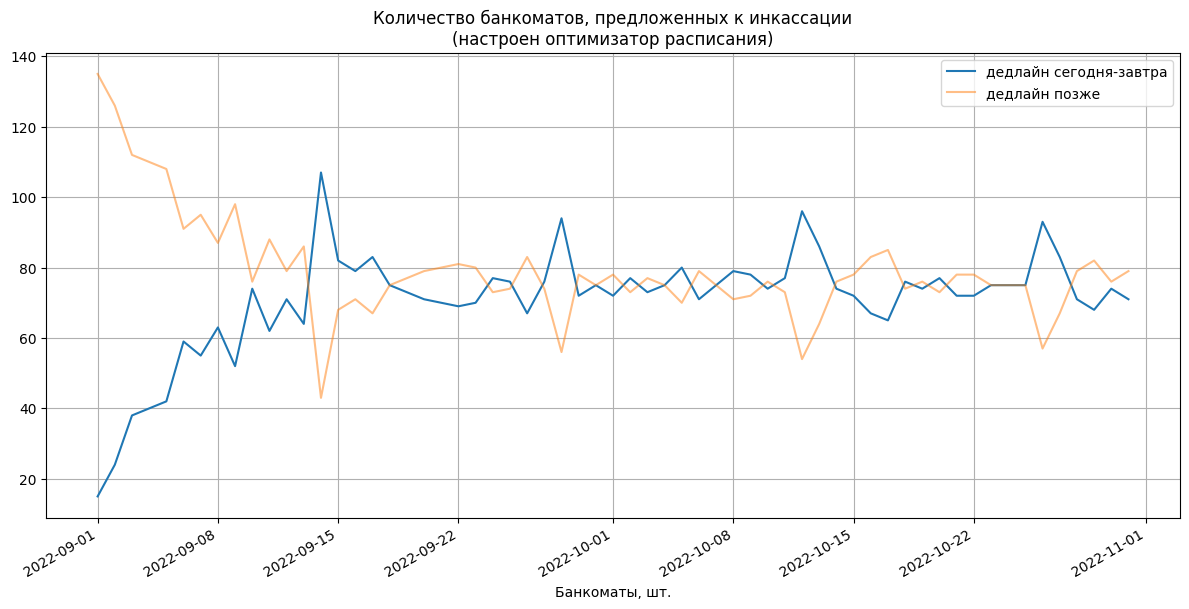

Среднее число 'обязательных' банкоматов, инкассируемое за день: 71.0


In [38]:
horizon = 14
deadline_thresh = 1
atms_per_day = 150
neighborhood_radius = 15
use_greedy = False

residuals = initial_residuals.copy()
today = scheduler.get_today_from_residuals(residuals)

end_date = pd.to_datetime('2022-10-31')

dates_list, n_mandatory_atms_list, n_other_atms_list, resids_list = [], [], [], []

while today < end_date:
    tomorrow = today + pd.Timedelta(days=1)
    # прогнозируем сегодня с вечера, а объезжаем завтра
    dates_list.append(tomorrow)
    residuals = scheduler.prepare_residual_to_schedule_creation(residuals, lgbm_mdl, horizon=horizon)
    atms_for_today_collection = scheduler.get_atms_for_today_collection(loader,
                                                                        residuals,
                                                                        n_samples=atms_per_day,
                                                                        mandatory_selection_threshold=deadline_thresh,
                                                                        neighborhood_radius=neighborhood_radius,
                                                                        use_greedy=use_greedy)


    n_mandatory_atms = atms_for_today_collection['is_mandatory'].sum()
    n_other_atms = atms_for_today_collection.shape[0] - n_mandatory_atms

    n_mandatory_atms_list.append(n_mandatory_atms)
    n_other_atms_list.append(n_other_atms)

    collected_tids = atms_for_today_collection['TID'].to_list()

    # обнуляем остатки и дату в инкассированных банкоматах
    collected_cond = residuals['TID'].isin(collected_tids)
    residuals['date'] = tomorrow
    residuals.loc[collected_cond, 'money'] = 0
    residuals.loc[collected_cond, 'last_collection_date'] = tomorrow
    residuals.loc[collected_cond, 'overflow_date'] = pd.NaT

    # считаем остаток на вечер дня инкассации, зная income за этот день
    resid_money = residuals.set_index('TID')['money']
    income_money = incomes_df.set_index('TID')
    income_money = income_money.loc[income_money['date']==tomorrow, 'money_in']
    income_money = income_money[resid_money.index]

    residuals['money'] = (resid_money + income_money).values
    resids_list.append(residuals)

    today = tomorrow

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.Series(data=n_mandatory_atms_list, index=dates_list), label='дедлайн сегодня-завтра')
plt.plot(pd.Series(data=n_other_atms_list, index=dates_list), label='дедлайн позже', alpha=.5)
plt.title('Количество банкоматов, предложенных к инкассации\n(настроен оптимизатор расписания)')
fig.autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.xlabel('Банкоматы, шт.')
plt.grid()

plt.show()

print("Среднее число 'обязательных' банкоматов, инкассируемое за день:", round(np.mean(n_mandatory_atms_list), 0))

In [20]:
all_resids = pd.concat(resids_list, ignore_index=True)

In [22]:
%autoreload 2

n_iterations = 1
max_route_time = 720

residuals = initial_residuals.copy()

today = scheduler.get_today_from_residuals(residuals) 

end_date = pd.to_datetime('2022-11-30')

dates, routes, routes_times, n_cars, n_atms, max_route_times = [], [], [], [], [], []

while today < end_date:
    tomorrow = today + pd.Timedelta(days=1)
    # прогнозируем сегодня с вечера, а объезжаем завтра
    dates.append(tomorrow)

    residuals = scheduler.prepare_residual_to_schedule_creation(residuals, lgbm_mdl, horizon=horizon)

    day_routes, day_routes_times, day_max_route_time, day_min_route_time = ortools_tsp.optimize_routes(
        loader,
        residuals,
        atms_per_day=atms_per_day,
        mandatory_selection_threshold=deadline_thresh,
        n_iterations=n_iterations,
        neighborhood_radius=neighborhood_radius,
        max_route_time=max_route_time,
        mandatory_selection_col='days_to_deadline',
        tids_col='TID',
        use_greedy=use_greedy
        )

    full_day_route = []
    for _, _route in day_routes.items():
        full_day_route += _route

    day_n_cars = len(day_routes)
    day_atms = len(full_day_route)

    n_cars.append(day_n_cars)
    routes.append(day_routes)
    routes_times.append(day_routes_times)
    n_atms.append( day_atms )
    max_route_times.append ( day_max_route_time )

    print(today,
          day_atms,
          day_n_cars,
          round(day_max_route_time, 2),
          round(day_min_route_time, 2))

    # обнуляем остатки и дату в инкассированных банкоматах
    collected_cond = residuals['TID'].isin(full_day_route)
    residuals['date'] = tomorrow
    residuals.loc[collected_cond, 'money'] = 0
    residuals.loc[collected_cond, 'last_collection_date'] = tomorrow
    residuals.loc[collected_cond, 'overflow_date'] = pd.NaT

    # считаем остаток на вечер дня инкассации, зная income за этот день
    resid_money = residuals.set_index('TID')['money']
    income_money = incomes_df.set_index('TID')
    income_money = income_money.loc[income_money['date']==tomorrow, 'money_in']
    income_money = income_money[resid_money.index]

    residuals['money'] = (resid_money + income_money).values

    today = tomorrow

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:265: UserWarning: Дата 2022-08-31 00:00:00 не найдена в данных, прогнозируем средним по TID
  warn(f'Дата {today_date} не найдена в данных, прогнозируем средним по TID')


2022-08-31 00:00:00 160 4 717.23 319.57
2022-09-01 00:00:00 160 4 712.33 449.05
2022-09-02 00:00:00 160 5 719.89 328.23
2022-09-03 00:00:00 160 5 716.83 287.17
2022-09-04 00:00:00 160 5 715.01 291.54
2022-09-05 00:00:00 160 5 711.84 549.2
2022-09-06 00:00:00 160 5 708.4 617.96
2022-09-07 00:00:00 160 5 716.92 563.89
2022-09-08 00:00:00 160 5 718.36 334.79
2022-09-09 00:00:00 160 6 714.62 125.25
2022-09-10 00:00:00 160 5 716.05 674.06
2022-09-11 00:00:00 160 6 715.44 32.85
2022-09-12 00:00:00 160 5 715.98 519.35
2022-09-13 00:00:00 160 7 715.21 101.63
2022-09-14 00:00:00 160 5 718.4 10
2022-09-15 00:00:00 160 5 718.07 200.41
2022-09-16 00:00:00 160 5 719.8 439.87
2022-09-17 00:00:00 160 5 709.94 332.87
2022-09-18 00:00:00 160 5 718.36 421.49
2022-09-19 00:00:00 160 5 717.46 384.02
2022-09-20 00:00:00 160 5 717.74 548.62
2022-09-21 00:00:00 160 5 718.93 666.14
2022-09-22 00:00:00 160 5 718.07 269.16
2022-09-23 00:00:00 160 6 717.19 10
2022-09-24 00:00:00 160 6 718.17 27.27
2022-09-25 00:

In [23]:
dfs_list = []

for _date, _route in zip(dates, routes):
    for _car, _car_route in _route.items():
        df = pd.DataFrame(columns=['TID', 'date', 'auto'])
        df['TID'] = _car_route
        df['auto'] = _car
        df['date'] = _date
        dfs_list.append(df)

result = pd.concat(dfs_list)

In [24]:
df_money_sum = output.find_ATM_balance_evening(result, loader)
all_cost = output.find_all_cost(df_money_sum, result, loader)

check_conditions.condition_max_days_inc(result, incomes_df, loader)
check_conditions.check_over_balance(result, loader)

100%|██████████| 91/91 [00:10<00:00,  8.65it/s]


,2022-09-01,2022-09-02,2022-09-03,2022-09-04,2022-09-05,2022-09-06,2022-09-07,2022-09-08,2022-09-09,2022-09-10,...,2022-11-21,2022-11-22,2022-11-23,2022-11-24,2022-11-25,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30
406136,160000,250000,355000,454000,561000,671000,731000,806000,895000,0,...,87000,178000,256000,256000,421000,421000,610000,716000,810000,0
406139,387000,490000,696000,0,124000,202000,367000,0,0,88000,...,0,164000,317000,468000,0,206000,0,123000,261000,373000
406145,287000,430000,566000,690000,807000,0,140000,279000,417000,535000,...,307000,426000,526000,0,169000,287000,405000,0,128000,249000
406148,355000,405000,478000,531000,596000,671000,771000,824000,876000,0,...,751000,0,55000,120000,205000,300000,368000,430000,430000,548000
406180,597000,693000,775000,846000,918000,0,55000,110000,185000,260000,...,723000,805000,861000,0,59000,164000,234000,311000,398000,457000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699578,47000,47000,0,10000,10000,20000,26000,26000,51000,51000,...,0,35000,45000,55000,69000,96000,106000,106000,151000,194000
699579,236000,285000,0,0,0,13000,63000,63000,195000,230000,...,49000,136000,204000,293000,374000,412000,412000,412000,516000,579000
699629,67000,130000,193000,256000,320000,394000,394000,515000,578000,650000,...,608000,663000,0,53000,100000,154000,209000,263000,310000,372000
699641,278000,341000,0,0,51000,51000,51000,128000,128000,168000,...,372000,0,48000,48000,48000,144000,144000,183000,183000,268000


In [25]:
display(df_money_sum)
display(all_cost)

,2022-09-01,2022-09-02,2022-09-03,2022-09-04,2022-09-05,2022-09-06,2022-09-07,2022-09-08,2022-09-09,2022-09-10,...,2022-11-22,2022-11-23,2022-11-24,2022-11-25,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30,2022-08-31
406136,250000,355000,454000,561000,671000,731000,806000,895000,990000,116000,...,256000,256000,421000,421000,610000,716000,810000,885000,74000,160000
406139,490000,696000,864000,124000,202000,367000,531000,174000,88000,328000,...,317000,468000,625000,206000,388000,123000,261000,373000,552000,387000
406145,430000,566000,690000,807000,930000,140000,279000,417000,535000,661000,...,526000,705000,169000,287000,405000,519000,128000,249000,373000,287000
406148,405000,478000,531000,596000,671000,771000,824000,876000,958000,63000,...,55000,120000,205000,300000,368000,430000,430000,548000,618000,355000
406180,693000,775000,846000,918000,1004000,55000,110000,185000,260000,333000,...,861000,931000,59000,164000,234000,311000,398000,457000,512000,597000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699578,47000,47000,10000,10000,20000,26000,26000,51000,51000,56000,...,45000,55000,69000,96000,106000,106000,151000,194000,314000,47000
699579,285000,353000,0,0,13000,63000,63000,195000,230000,272000,...,204000,293000,374000,412000,412000,412000,516000,579000,673000,236000
699629,130000,193000,256000,320000,394000,394000,515000,578000,650000,707000,...,712000,53000,100000,154000,209000,263000,310000,372000,422000,67000
699641,341000,341000,0,51000,51000,51000,128000,128000,168000,168000,...,48000,48000,48000,144000,144000,183000,183000,268000,313000,278000


,Затраты на инкасацию,Затраты на фондирование,Затраты на машины
2022-09-01,15900.0,25485.863014,140000
2022-09-02,15900.0,27764.876712,140000
2022-09-03,15900.0,29168.493151,140000
2022-09-04,16000.0,30143.068493,140000
2022-09-05,16000.0,29934.849315,140000
...,...,...,...
2022-11-26,15900.0,22757.808219,140000
2022-11-27,16000.0,22891.452055,140000
2022-11-28,15800.0,22722.027397,140000
2022-11-29,16000.0,22651.178082,140000


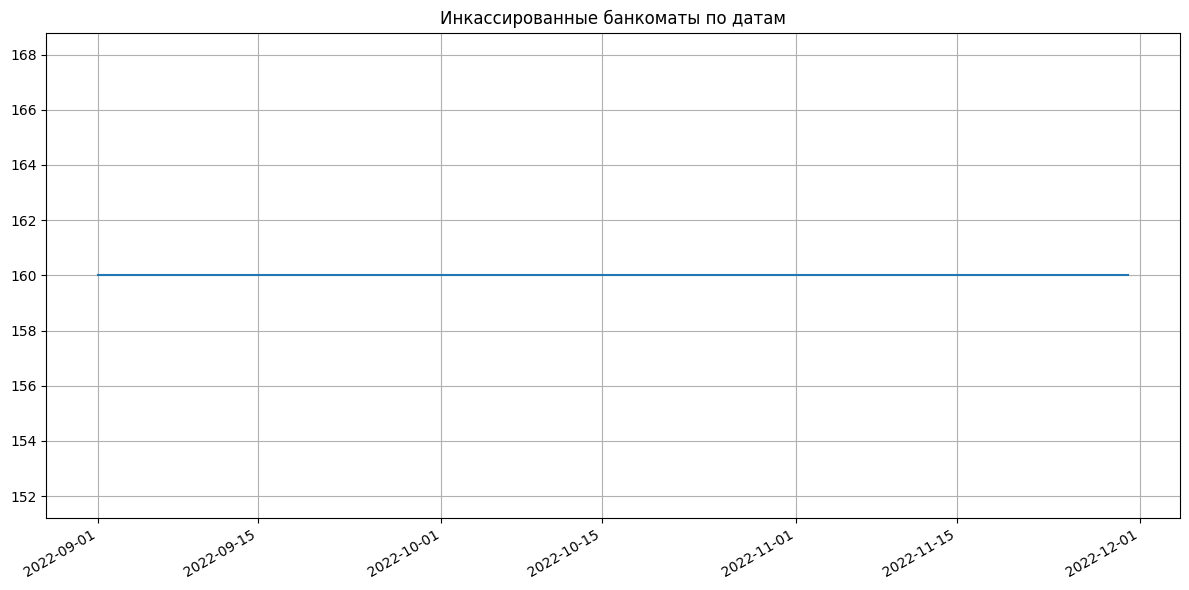

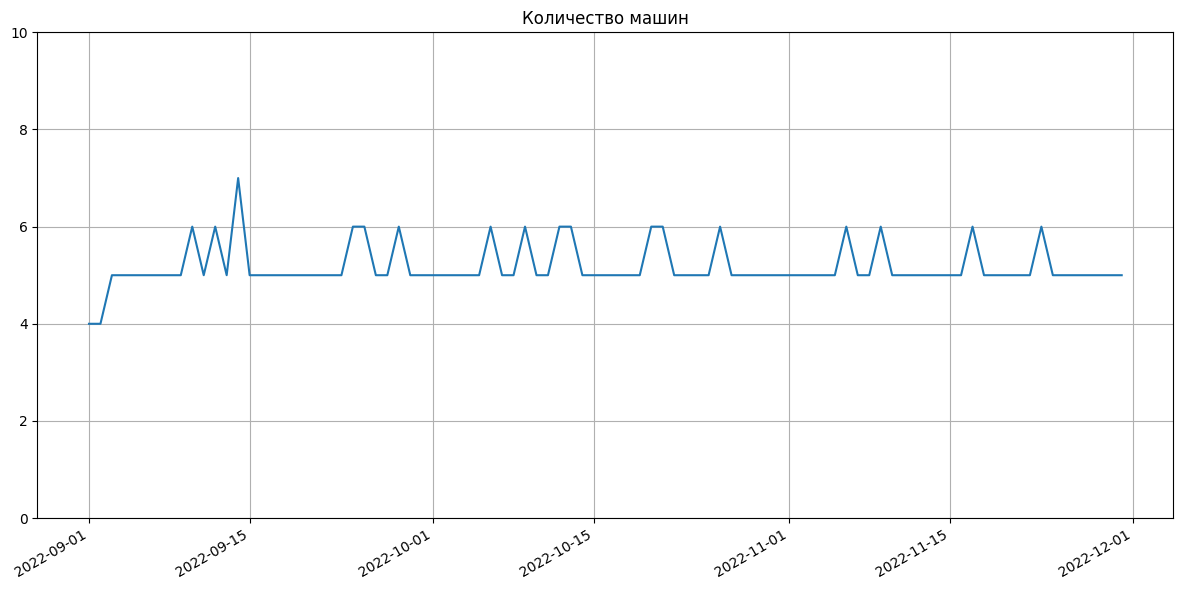

In [26]:
routes_series = pd.Series(index=dates, data=n_atms)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.Series(data=routes_series, index=dates))
plt.title('Инкассированные банкоматы по датам')
fig.autofmt_xdate()
plt.tight_layout()
plt.grid()
plt.show()

cars_series = pd.Series(index=dates, data=n_cars)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.Series(data=cars_series, index=dates))
plt.title('Количество машин')
fig.autofmt_xdate()
plt.tight_layout()
plt.ylim(0,10)
plt.grid()
plt.show()

In [27]:
result_geo = result.reset_index().merge(geo_df)

result_geo = result_geo.sort_values(by=['date', 'auto', 'index']).reset_index(drop=True)

In [28]:
date = '2022-09-15'

geoplot_df = result_geo[result_geo['date']==date].copy()

bsplot.geoplot_clusters(geoplot_df,
                        'auto')

In [29]:
geoplot_df

,index,TID,date,auto,longitude,latitude
2240,0,606520,2022-09-15,1,37.954339,55.708243
2241,1,406139,2022-09-15,1,37.932528,55.701643
2242,2,622396,2022-09-15,1,37.899199,55.689851
2243,3,635511,2022-09-15,1,37.895328,55.676994
2244,4,616654,2022-09-15,1,37.884742,55.670710
...,...,...,...,...,...,...
2395,40,682273,2022-09-15,4,38.026187,55.749683
2396,41,645387,2022-09-15,4,38.015737,55.742321
2397,42,680328,2022-09-15,4,38.005677,55.742343
2398,43,661116,2022-09-15,4,37.996686,55.741563


Демонстрация работы шедулера по поиску ближайших банкоматов к тем, которые необходимо инкассировать

In [30]:
tids_sample = geo_df['TID'].sample(n=10, random_state=0).to_list()

nearest = scheduler.get_neighbours(tids_sample, loader, radius=10)

to_plot = geo_df.loc[geo_df['TID'].isin(nearest + tids_sample), :].copy()
to_plot['main_pair'] = to_plot['TID'].isin(tids_sample)

bsplot.geoplot_clusters(to_plot, 'main_pair', html_folder=INTERIM_DATA_FOLDER)

In [31]:
import plotly.express as px

# for auto in geoplot_df['auto'].unique():

#     plt.plot(geoplot_df.loc[geoplot_df['auto']==auto, ['latitude', 'longitude']].set_index('latitude'))
# plt.show()


fig = px.line_geo(geoplot_df,
                  color='auto',
                  lat='latitude',
                  lon='longitude')
fig.update_geos(fitbounds="locations")
fig.update_layout(height=500, width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()